# Юнит-экономика и когортный анализ. Расчет и анализ LTV, ROI, удержания и конверсии

## Поставленная задача

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

### Описание данных

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd  # Загрузили необходимые библиотеки
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

visits = pd.read_csv('/datasets/visits_info_short.csv')  # Загрузили данные из файлов
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [2]:
visits.info() # Смотрим информацию о столбцах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [4]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропущенных значений нет. Названия столбцов содержат пробелы и заглавные буквы. Дата и время в формате object. 

In [5]:
# Переименуем столбцы и посмотрим, как выглядят данные
visits = visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device', 'Channel': 'channel', 
                       'Session Start': 'session_start', 'Session End': 'session_end'})
display(visits.head())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [6]:
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})
display(orders.head())

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [7]:
costs = costs.rename(columns={'Channel': 'channel'})
display(costs.head())

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start']) # Перевели в формат дат
visits['session_end'] = pd.to_datetime(visits['session_end'])

## Функции для расчета и анализа LTV, ROI, удержания и конверсии



### Функция для расчёта удержания

Определим функцию **get_retention**(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False)
 
return: result_raw (сырые данные), result_grouped (таблица удержания), result_in_time (таблица динамики удержания)

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта конверсии

Определим функцию **get_conversion**(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False)
 
return: result_raw (сырые данные), result_grouped (таблица конверсии), result_in_time (таблица динамики конверсии).

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    
    result_raw['event_dt'] = pd.to_datetime(result_raw['event_dt'])
    result_raw['first_ts'] = pd.to_datetime(result_raw['first_ts'])
    
    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция для расчёта LTV и ROI

Определим функцию **get_ltv**(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False),
    
return: (
        result_raw (сырые данные), 
        result_grouped (таблица LTV),
        result_in_time (таблица динамики LTV),
        roi_grouped (таблица ROI),
        roi_in_time (таблица динамики ROI).

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
    result_raw['event_dt'] = pd.to_datetime(result_raw['event_dt'])
    result_raw['first_ts'] = pd.to_datetime(result_raw['first_ts'])
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

## Исследовательский анализ данных


### Создадим пользовательские профили и определим минимальную и максимальную дату привлечения пользователей.

Для определения границ дат привлечения сгруппируем данные таблицы visits по 'user_id', применим функцию min() к 'session_start', затем к получившимся минимальным (первым) значениям 'session_start' применим функции min() и max():

In [12]:
print(visits
      .groupby('user_id').agg({'session_start': 'min'})
      .agg({'session_start': ['min', 'max']})
)

          session_start
min 2019-05-01 00:00:41
max 2019-10-27 23:59:04


Определим функцию **get_profiles**(sessions, orders, ad_costs), return: profiles

In [13]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs): #events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
        
    ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])
    new_users['dt'] = pd.to_datetime(new_users['dt'])
    
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
        
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left'
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Применим функцию get_profiles и создадим пользовательские профили profiles_users.

In [14]:
profiles_users = get_profiles(visits, orders, costs)  
display(profiles_users.head(10))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


### Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?





In [15]:
country_users = (
        profiles_users.groupby(['region'])
        .agg({'payer': ['sum', 'count']})
        .reset_index()
    )
country_users.columns = ['region', 'amount_payers', 'amount_all_users']

country_users['ratio_payers'] = country_users['amount_payers'] / country_users['amount_all_users']
display(country_users.sort_values(by='amount_payers', ascending=False).reset_index(drop=True))       

,region,amount_payers,amount_all_users,ratio_payers
0,United States,6902.0,100002,0.069019
1,UK,700.0,17575,0.039829
2,France,663.0,17450,0.037994
3,Germany,616.0,14981,0.041119


Больше всего платящих пользователей в USA, причем не только в абсолютном выражении, но и в процентном соотношении.

###  Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

In [16]:
device_users = (
        profiles_users.groupby(['device'])
        .agg({'payer': ['sum', 'count']})
        .reset_index()
    )
device_users.columns = ['device', 'amount_payers', 'amount_all_users']

device_users['ratio_payers'] = device_users['amount_payers'] / device_users['amount_all_users']
display(device_users.sort_values(by='amount_payers', ascending=False).reset_index(drop=True))  

,device,amount_payers,amount_all_users,ratio_payers
0,iPhone,3382.0,54479,0.062079
1,Android,2050.0,35032,0.058518
2,Mac,1912.0,30042,0.063644
3,PC,1537.0,30455,0.050468


Большинство покупок происходят с iPhone, но наибольшая доля платящих пользователей принадлежит владельцам Mac, от которых лишь немного отстают пользователи iPhone. 

###  По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [17]:
channel_users = (
        profiles_users.groupby(['channel'])
        .agg({'payer': ['sum', 'count']})
        .reset_index()
    )
channel_users.columns = ['channel', 'amount_payers', 'amount_all_users']

channel_users['ratio_payers'] = channel_users['amount_payers'] / channel_users['amount_all_users']
display(channel_users.sort_values(by='amount_payers', ascending=False).reset_index(drop=True))  

,channel,amount_payers,amount_all_users,ratio_payers
0,FaceBoom,3557.0,29144,0.122049
1,TipTop,1878.0,19561,0.096007
2,organic,1160.0,56439,0.020553
3,WahooNetBanner,453.0,8553,0.052964
4,AdNonSense,440.0,3880,0.113402
5,RocketSuperAds,352.0,4448,0.079137
6,LeapBob,262.0,8553,0.030633
7,OppleCreativeMedia,233.0,8605,0.027077
8,lambdaMediaAds,225.0,2149,0.104700
9,YRabbit,165.0,4312,0.038265


Лидером и по числу платящих пользователей, как по количеству, так и по доле от общего числа, стал канал FaceBoom.

## Маркетинг

### Сколько денег потратили? Всего / на каждый источник / по времени

Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам и по времени. Визуализируем изменения метрик во времени.

In [18]:
print('Общая сумма расходов на маркетинг:', round(costs['costs'].sum(), 2))

Общая сумма расходов на маркетинг: 105497.3


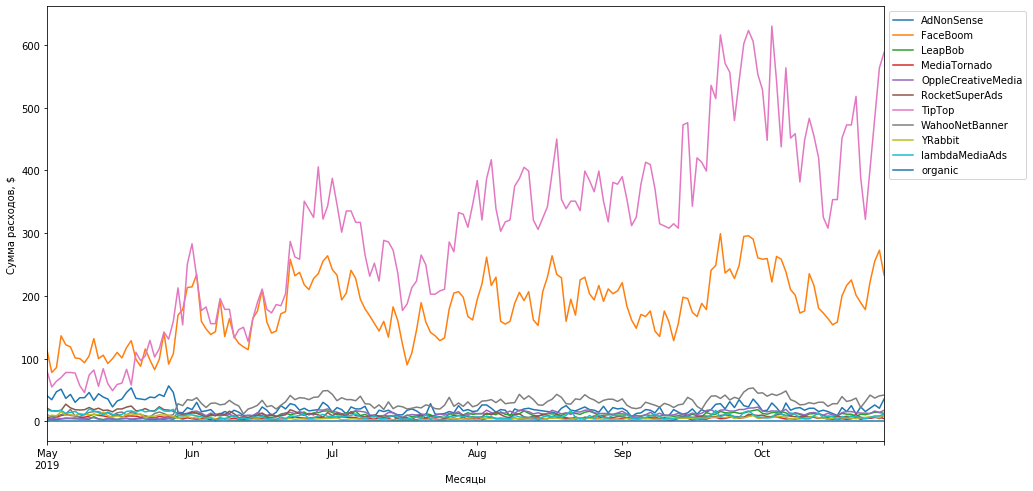

In [19]:
profiles_users.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='sum').plot(figsize=(15,8))
plt.xlabel('Месяцы') #  ось X
plt.ylabel('Сумма расходов, $') #  ось Y
plt.legend(bbox_to_anchor=(1, 1))  # Сдвинули легенду
plt.show()


По построенной сводной таблице видно, что самые высокие затраты в начале периода у FaceBoom, затем идут TipTop и AdNonSense, но к концу периода затраты на AdNonSense падают, а у первых двух источников рекламы вырастают в несколько раз, причем у TipTop они становятся примерно в два раза выше, чем у FaceBoom. 

### Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Для этого рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. 

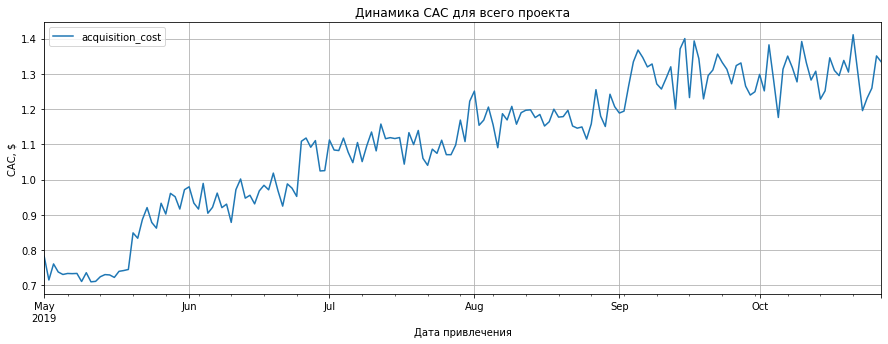

In [20]:
# строим график истории изменений CAC суммарно по всем каналам привлечения, исключая Organic.

profiles_users.query('channel != "organic"').pivot_table(
        index='dt', values='acquisition_cost', aggfunc='mean').plot(grid=True, figsize=(15, 5))
    
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС для всего проекта')

plt.show()

CAC растет в целом, в сентябре и октябре остается примерно на одном уровне, около 1,3$.

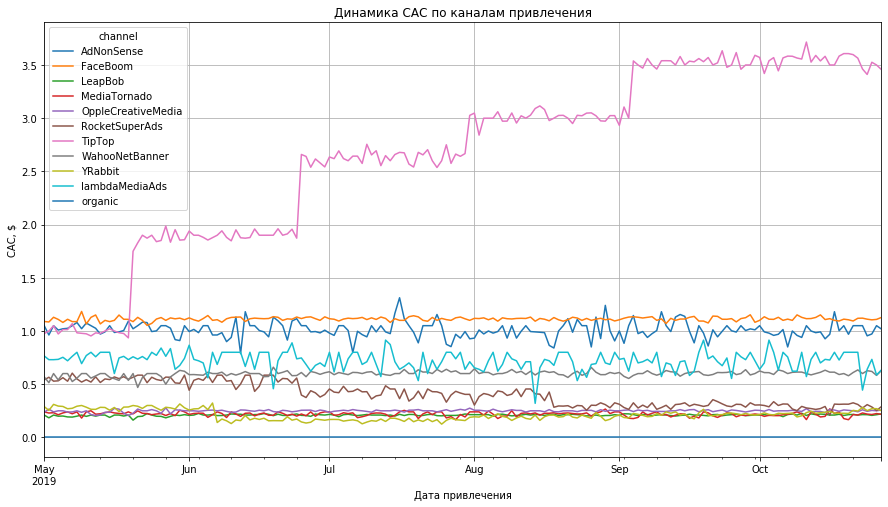

In [21]:
# строим график истории изменений CAC по каналам привлечения

profiles_users.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 8))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')

plt.show()

Как видно из графиков, общее увеличение стоимости привлечения одного клиента достигается за счет роста CAC по каналу TipTop, превышающего к концу октября стабильные показатели остальных каналов примерно в 7 раз.

## Оценка окупаемости рекламы для привлечения пользователей с помощью LTV и ROI

### Анализ общей окупаемости рекламы

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI. Присвоим переменным result_raw, ltv, ltv_history, roi, roi_history значения функции get_ltv и используем последние четыре при построении графиков.

Аргументами функции get_ltv будут датафреймы с профилями пользователей, покупками, момент анализа данных берем 27.10.2019 (хотя мы смотрим данные 1-го ноября 2019 года, но последний день, по которому есть данные - 27 октября 2019 года), горизонт анализа данных считаем 14 дней (в данной организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей). Параметр dimensions по умолчанию пустой (анализируем окупаемость рекламы в целом, без разбивки по признакам).

In [22]:
observation_date = datetime(2019, 10, 27).date()   # Задали момент анализа
horizon_days = 14                                  # Задали горизонт анализа

result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_users, orders, observation_date, horizon_days)

Определим функцию plot_ltv_roi для визуализации LTV, CAC и ROI и к ней вспомогательную функцию filter_data для сглаживания фрейма.

In [23]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 


In [24]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей CAC')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


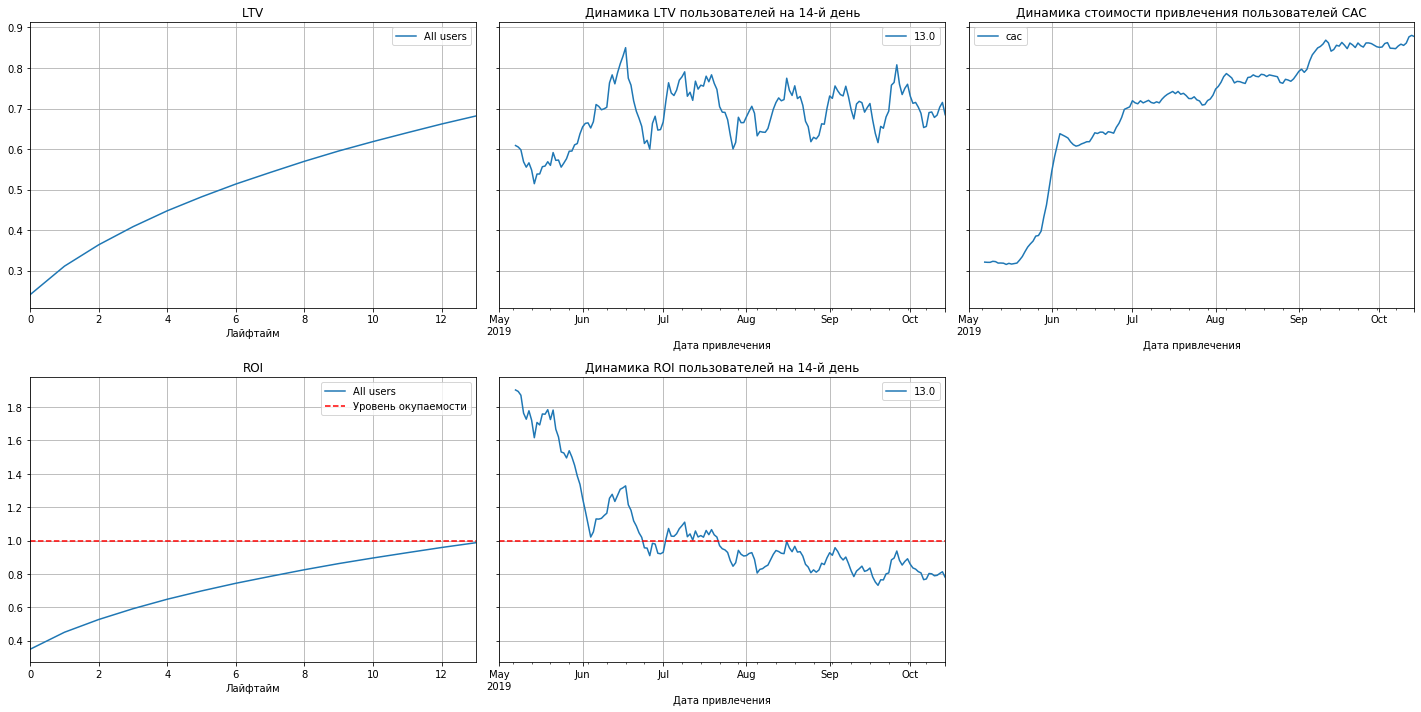

In [25]:
# Вызовем эту функцию для построения графиков по полученным выше значениям 
# с шириной окна сглаживания, равной 7 по умолчанию:

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days) # общая окупаемость рекламы

Реклама едва выходит на самоокупаемость: ROI к 14-му дню приблизилось к 1.
CAC растет скачкообразно, рекламный бюджет получает дополнительные вливания ежемесячно, а в июне вырос в несколько раз по сравнению с маем.
Показатель LTV достаточно стабилен, привлеченные клиенты приносят примерно одинаковый доход не зависимо от месяцев привлечения.

### Анализ окупаемости рекламы с разбивкой по устройствам

Аналогично построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI. В качестве параметра dimensions для функции get_ltv возьмем "device".

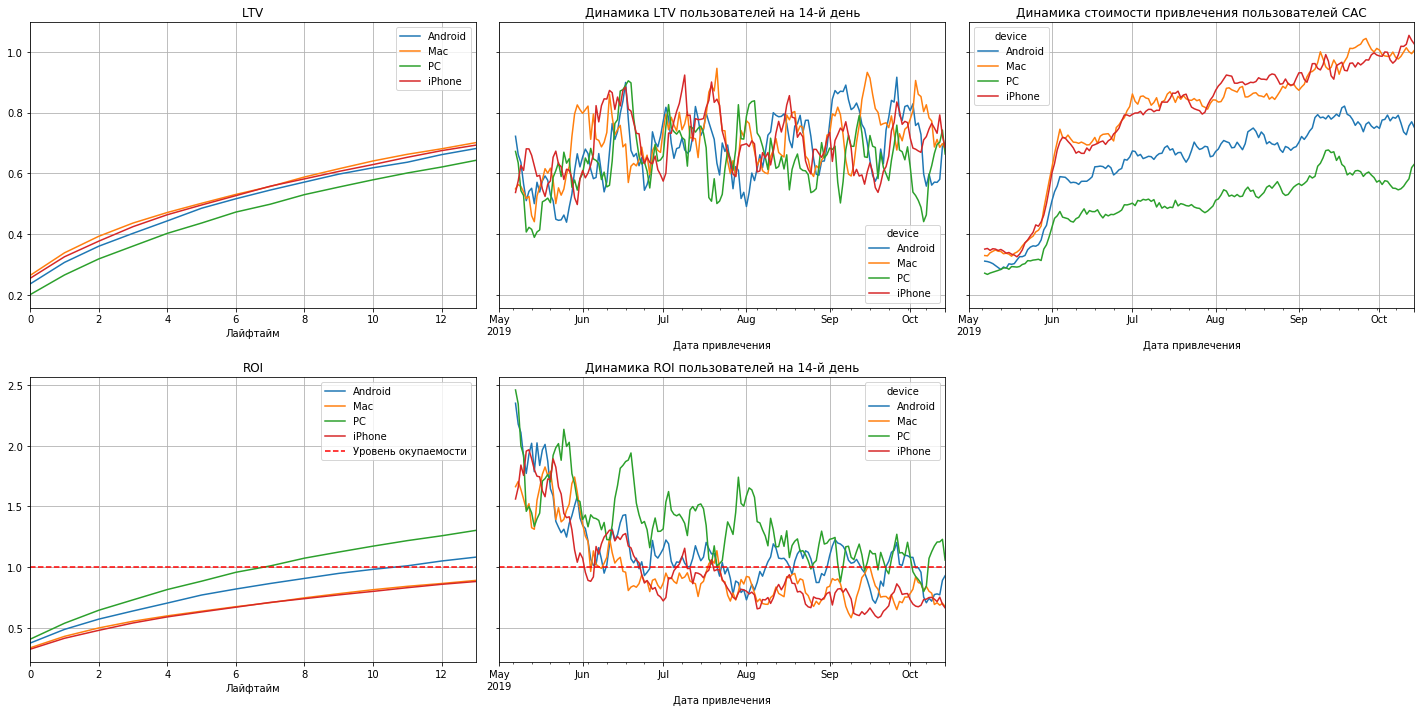

In [26]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_users, orders, observation_date, horizon_days, dimensions=['device'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Реклама окупается для PC уже через неделю, для Android через десять дней, а вот реклама на платформах "яблочных" MAC и IPhone при горизонте анализа в 14 дней не окупаются. И хотя при анализе источников привлечения клиентов они показали больший процент платящих пользователей, стоимость рекламы для них растет быстрее, что видно из графика CAC, что и приводит к ROI < 1. 

### Анализ окупаемости рекламы с разбивкой по странам

Код практически тот же, но в качестве параметра dimensions берем "region".

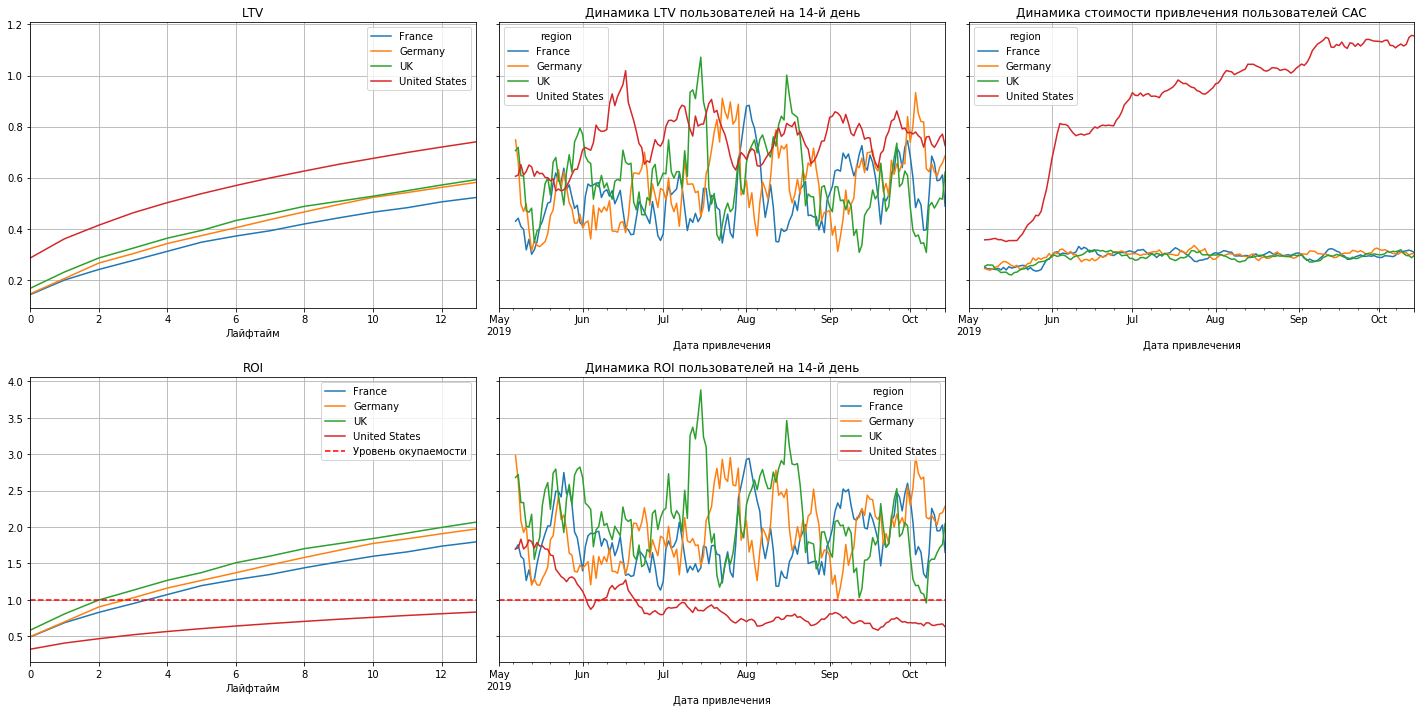

In [27]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_users, orders, observation_date, horizon_days, dimensions=['region'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

ROI > 1 для UK, Германии и Франции, а с рекламой в США "всё плохо": на уровень окупаемости она не выходит, динамика окупаемости падает практически сразу, и со второй декады июня уже не поднимается до 1. Связано с непомерно завышенными расходами на рекламу (график CAC).  И хотя в США привлечено примерно в десять раз больше пользователей, чем в каждом из прочих регионов, расходы на рекламу не оправдываются.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

dimensions = "channel".

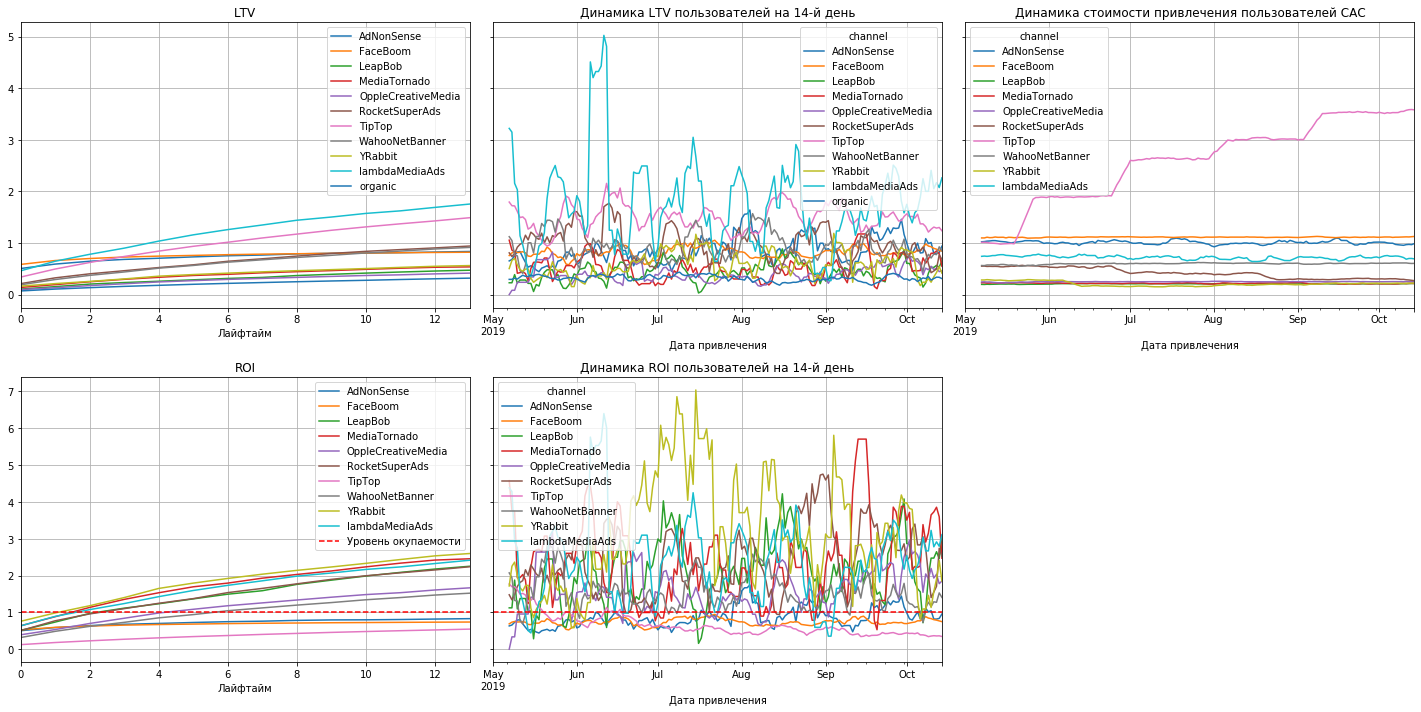

In [28]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_users, orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Самый высокий показатель LTV у LambdaMediaAds и TipTop, но у TipTop самая высокая динамика CAC, которая дает самое низкое значение ROI. Вообще самые высокие расходы на рекламу, как мы видели ранее, у TipTop и FaceBoom, они и привели к самым низким значениям ROI.

Наибольшее значение ROI у YRabbit, у этого же канала лучшая динамика ROI на протяжении двух летних месяцев и в первой половине сентября, а стоимость привлечения CAC стабильно низкая, что позволяет выйти на окупаемость уже на второй день и дает преимущества при подсчете окупаемости клиентов по сравнению с остальными каналами.

###  Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

Посчитаем удержание с помощью функции get_retention, передав ей в качестве аргументов таблицы профилей пользователей и сессий (visits), момент наблюдения 2019-10-27 и горизонт 14 дней, а в качестве параметра dimensions - device, region, channel.
Посчитаем конверсию с помощью функции get_conversion (аргументы - профили, покупки orders).
Затем вызовем функции  plot_retention для визуализации удержания и plot_conversion для визуализации конверсии (построение графиков) с разбивкой по устройствам, странам, рекламным каналам.

In [29]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [30]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

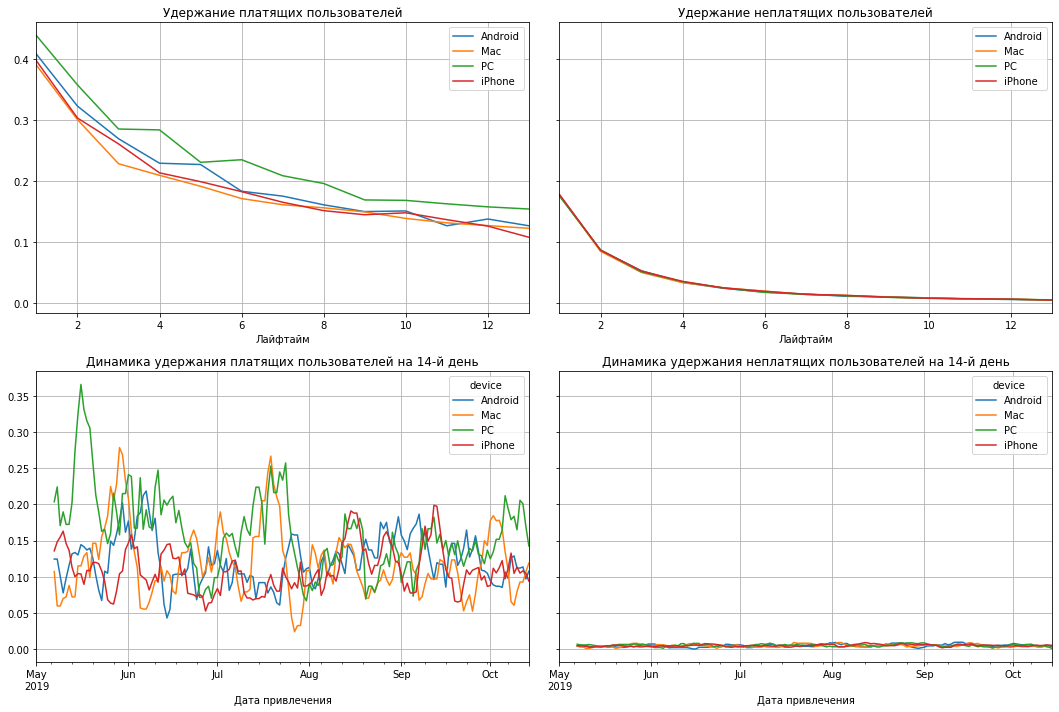

In [31]:
# Считаем удержание с разбивкой по используемым устройствам.
result_raw, result_grouped, result_in_time = get_retention(
    profiles_users, visits, observation_date, horizon_days, dimensions=['device'])

# Вызываем функцию построения графиков удержания
plot_retention(result_grouped, result_in_time, horizon_days)

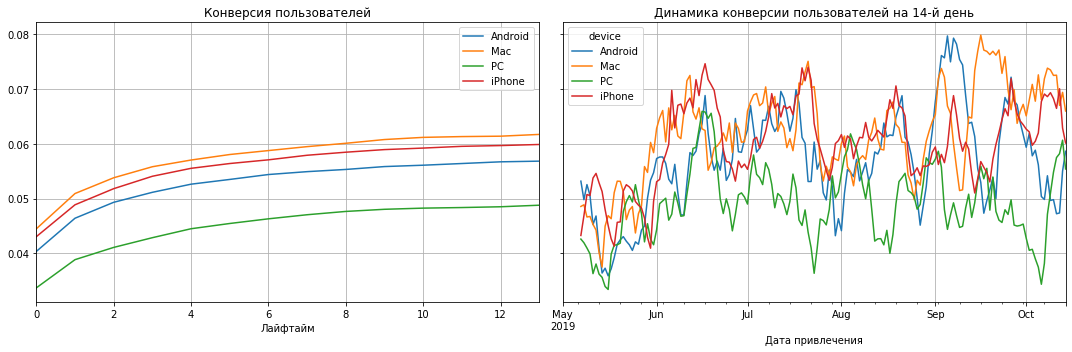

In [32]:
# Считаем конверсию с разбивкой по используемым устройствам.
result_raw, result_grouped, result_in_time = get_conversion(
    profiles_users, orders, observation_date, horizon_days, dimensions=['device'])
# Вызываем функцию визуализации конверсии.
plot_conversion(result_grouped, result_in_time, horizon_days)

Удержание не очень высокое, но по всем устройствам примерно одинаковое, на PC немного выше. А вот конверсия для персональных компьютеров намного ниже, чем для других типов устройств.

Удержание неплатящих пользователей убывает намного быстрее, чем платящих, и одинаково для всех типов устройств.

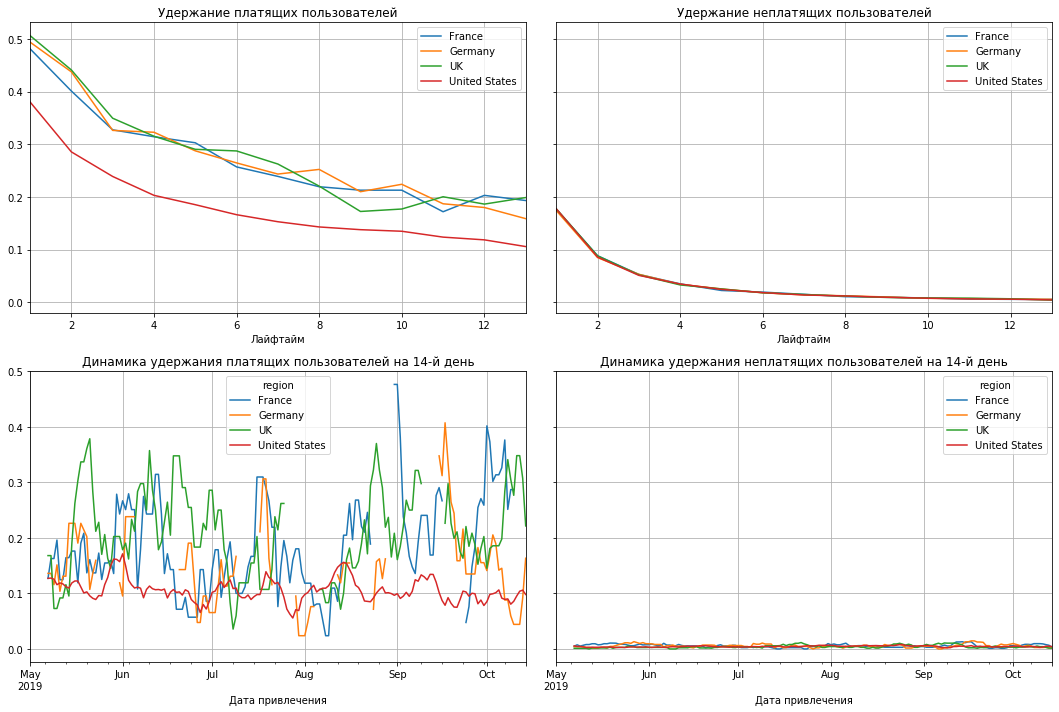

In [33]:
# Считаем удержание с разбивкой по странам.
result_raw, result_grouped, result_in_time = get_retention(
    profiles_users, visits, observation_date, horizon_days, dimensions=['region'])

plot_retention(result_grouped, result_in_time, horizon_days)

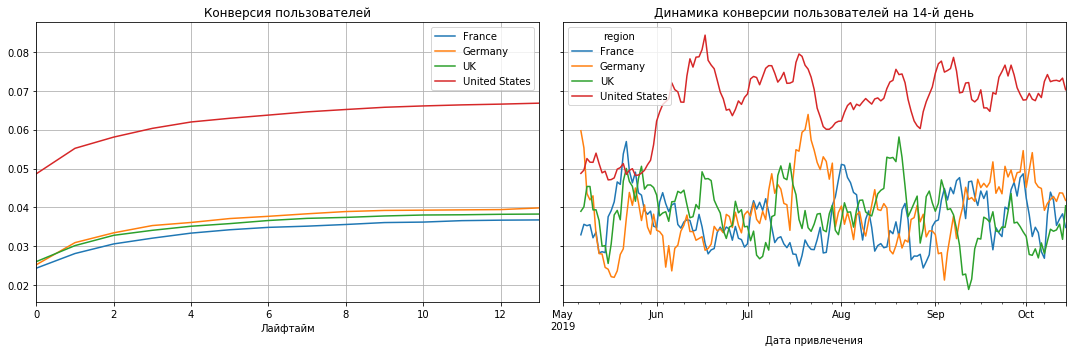

In [34]:
# Считаем конверсию с разбивкой по странам.
result_raw, result_grouped, result_in_time = get_conversion(
    profiles_users, orders, observation_date, horizon_days, dimensions=['region'])

plot_conversion(result_grouped, result_in_time, horizon_days)

Наблюдаем высокую конверсию покупателей в США, более чем в два раза превышающую конверсию в других странах, а вот удержание платящих пользователей в США, наоборот, ниже. То есть там чаще совершают первую покупку, но реже делают вторую.

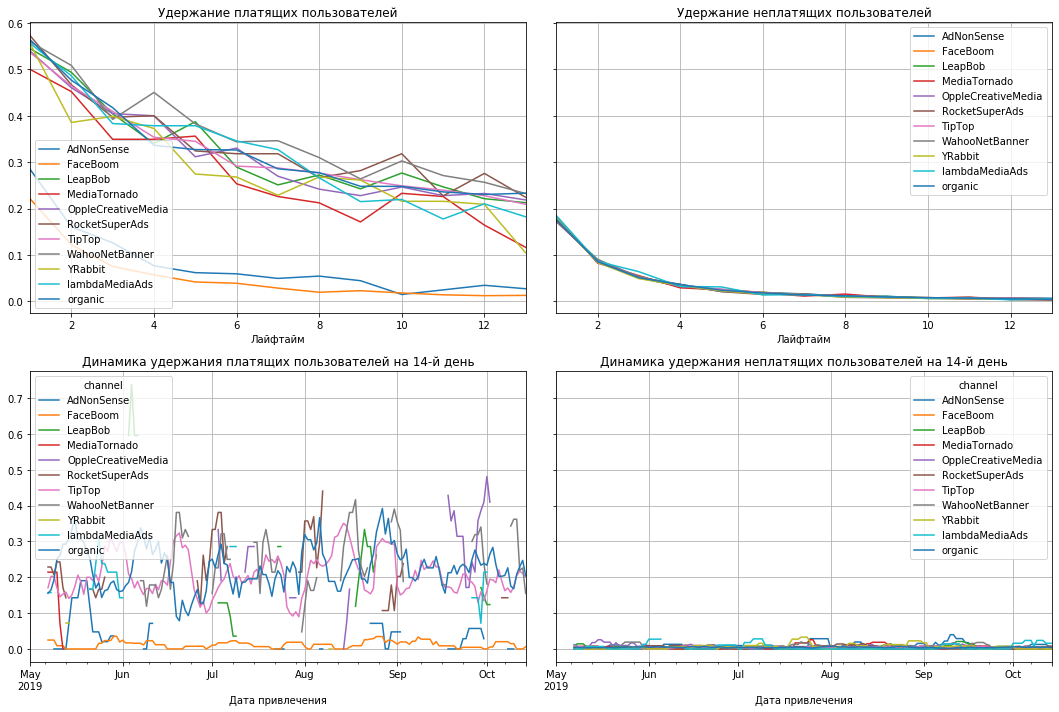

In [35]:
# Считаем удержание с разбивкой по рекламным каналам.
result_raw, result_grouped, result_in_time = get_retention(
    profiles_users, visits, observation_date, horizon_days, dimensions=['channel'])

plot_retention(result_grouped, result_in_time, horizon_days)

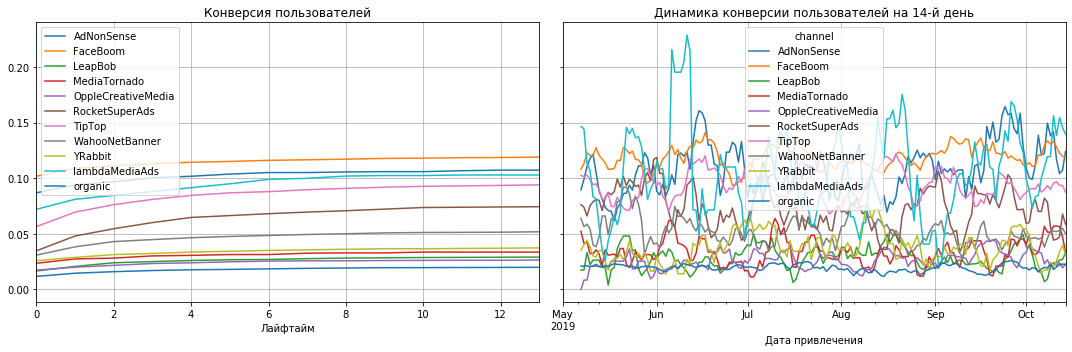

In [36]:
# Считаем конверсию с разбивкой по рекламным каналам.
result_raw, result_grouped, result_in_time = get_conversion(
    profiles_users, orders, observation_date, horizon_days, dimensions=['channel'])

plot_conversion(result_grouped, result_in_time, horizon_days)

Конверсия выше всего у пользователей, привлеченных через каналы FaceBoom и AdNonSense, но удержание платящих среди них, наоборот, значительно ниже, чем у остальных. 

### Выводы по окупаемости

Реклама, направленная на привлечение пользователей в целом, не окупается. 

На общую окупаемость рекламы могут оказывать негативное влияние (снижать ее) следующие факторы: использование пользователями таких устройств, как MAC и IPhone (возможно, проблема в отражении сайтов на этих платформах); слишком большие затраты на привлечение пользователей в USA; неоправданные расходы на рекламные каналы TipTop и FaceBoom.

Возможно, причина именно в чрезмерных расходах на рекламу по отдельным странам (USA), каналам и устройствам.

Рекомендации для рекламного отдела: уделять больше внимания на привлечение пользователей из тех каналов, которые показывают более стабильные результаты и меньше на TipTop и FaceBoom; снизить расходы на рекламу по США, а также направленные на пользователей IPhone и MAC.

## Общие выводы
Общие причины неэффективности привлечения пользователей кроются в неоправданно больших затратах по отдельным направлениям и и низком удержании пользователей, хотя и показавших высокую конверсию.

Для повышения эффективности рекламы следует снизить расход на рекламный канал TipTop, увеличить рекламу для PC и Android, а в США попытаться найти другую целевую аудиторию, так как при больших затратах на привлечение оттуда идет большое число пользователей, не заинтересованных в повторных покупках.